In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [45]:
plotsize_subplots = (cm2inch(5),cm2inch(5))

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 6

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [6]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [7]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [29]:
def plot_compare(df, name, values, index=None, legend_loc='lower right', rot=45, logy=False,
                 color=None, plot_kind='bar'):
    """Plot times for different cases"""
    
    if not index:
        index='N_VP'

    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=1)

    df_p[values[0]].plot(kind=plot_kind, ax = axes, title=values[0], fontsize=fontsize_axis, rot=rot,
                        logy=logy, legend=False, color=color)
    axes.legend(fontsize=fontsize_legends, loc=legend_loc)

    plt.subplots_adjust(wspace=0.5)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes.set_ylabel(r'Time [$\mu$s]')  # Not safe..
    elif 'Memory per VP' in values:
        # Assume memory is last entry in values
        axes.set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes.set_ylabel('Memory [B]')
    else:
        axes.set_ylabel('Time [s]')

    # x-axis labels
    axes.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')

## Benchmarks

### HPC Benchmark

In [19]:
hpc_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint.csv')
hpc_m['Case'] = ['Master (6d8d3047)'] * len(hpc_m)
hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_daint.csv')
hpc_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_m)

hpc = pd.concat([hpc_m, hpc_3])

hpc = calculate_T_conn_and_memory(hpc)

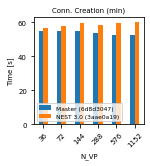

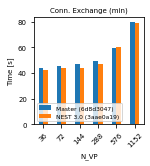

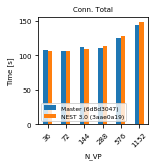

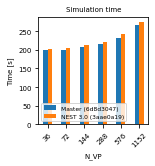

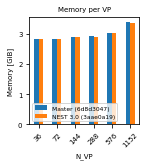

In [47]:
hpc['Simulation time'] = hpc['T_sim']

plot_compare(hpc, 'single_figures/hpc_benchmark_weak_scaling_Conn_Creation.pdf',
             values=['Conn. Creation (min)'], legend_loc='lower left')
plot_compare(hpc, 'single_figures/hpc_benchmark_weak_scaling_Conn_Exchange.pdf',
             values=['Conn. Exchange (min)'], legend_loc='lower left')
plot_compare(hpc, 'single_figures/hpc_benchmark_weak_scaling_Conn_Total.pdf',
             values=['Conn. Total'], legend_loc='lower left')
plot_compare(hpc, 'single_figures/hpc_benchmark_weak_scaling_simulation.pdf', values=['Simulation time'],
             legend_loc='lower left')
plot_compare(hpc, 'single_figures/hpc_benchmark_weak_scaling_MemoryperVP.pdf',
             values=['Memory per VP'], legend_loc='lower left')

### Population model

In [48]:
population_m = pd.read_csv('results/population_model_6d8d3047_daint_in.csv')
population_m['Case'] = ['Master (6d8d3047)'] * len(population_m)
population_3 = pd.read_csv('results/population_model_3_0_daint_in.csv')
population_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(population_m)

population = pd.concat([population_m, population_3])

population = calculate_T_conn_and_memory(population)

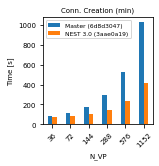

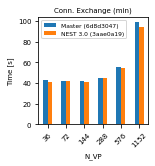

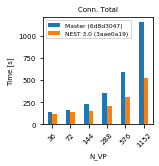

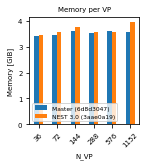

In [49]:
plot_compare(population, 'single_figures/population_model_weak_scaling_Conn_Creation.pdf',
             values=['Conn. Creation (min)'], legend_loc='upper left')
plot_compare(population, 'single_figures/population_model_weak_scaling_Conn_Exchange.pdf',
             values=['Conn. Exchange (min)'], legend_loc='upper left')
plot_compare(population, 'single_figures/population_model_weak_scaling_Conn_Total.pdf',
             values=['Conn. Total'], legend_loc='upper left')
plot_compare(population, 'single_figures/population_model_weak_scaling_MemoryperVP.pdf',
             values=['Memory per VP'], legend_loc='lower left')

### Multi-Area Model

In [50]:
MAM_m = pd.read_csv('results/multi-area_model_6d8d3047_daint.csv')
MAM_m['Case'] = ['Master (6d8d3047)'] * len(MAM_m)
MAM_3 = pd.read_csv('results/multi-area_model_3_0_daint.csv')
MAM_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(MAM_m)

MAM = pd.concat([MAM_m, MAM_3])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)

print(MAM['N_nrns'])
print(MAM['N_conns_sum'])

0     258258
1     516391
2    1032643
3    2065151
4    4130180
5    8260234
0     258257
1     516390
2    1032642
3    2065150
4    4130179
5    8260233
Name: N_nrns, dtype: int64
0     1508419407
1     3016843251
2     6033690822
3    12067386057
4    24134776576
5    48269557645
0     1508419407
1     3016843251
2     6033690822
3    12067386057
4    24134776576
5    48269557645
Name: N_conns_sum, dtype: int64


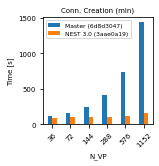

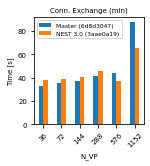

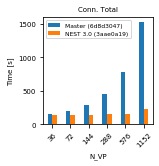

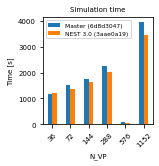

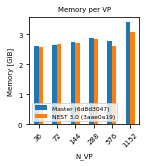

In [51]:
MAM['Simulation time'] = MAM['T_sim']

plot_compare(MAM, 'single_figures/multi-area_model_weak_scaling_Conn_Creation.pdf',
             values=['Conn. Creation (min)'], legend_loc='upper left')
plot_compare(MAM, 'single_figures/multi-area_model_weak_scaling_Conn_Exchange.pdf',
             values=['Conn. Exchange (min)'], legend_loc='upper left')
plot_compare(MAM, 'single_figures/multi-area_model_weak_scaling_Conn_Total.pdf',
             values=['Conn. Total'], legend_loc='upper left')
plot_compare(MAM, 'single_figures/multi-area_model_weak_scaling_simulation.pdf', values=['Simulation time'],
             legend_loc='upper left')
plot_compare(MAM, 'single_figures/multi-area_model_weak_scaling_MemoryperVP.pdf',
             values=['Memory per VP'], legend_loc='lower left')

### Different versions

In [52]:
hpc_214_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214_t1['Case'] = ['2.14']*len(hpc_214_t1)
hpc_216_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216_t1['Case'] = ['2.16']*len(hpc_216_t1)
hpc_218_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218_t1['Case'] = ['2.18']*len(hpc_218_t1)
hpc_m_t1   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_t1_s15.csv')
hpc_m_t1['Case']   = ['Master (6d8d3047)']*len(hpc_m_t1)
hpc_3_t1   = pd.read_csv('results/hpc_benchmark_3_0_daint_t1_s15.csv')
hpc_3_t1['Case']   = ['NEST 3.0 (3aae0a19)']*len(hpc_3_t1)

hpc_versions_t1 = pd.concat([hpc_214_t1, hpc_216_t1, hpc_218_t1, hpc_m_t1, hpc_3_t1])

hpc_versions_t1 = calculate_T_conn_and_memory(hpc_versions_t1)

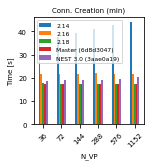

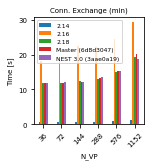

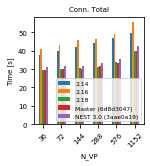

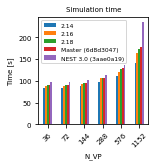

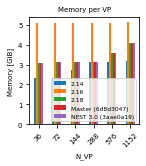

In [53]:
hpc_versions_t1['Simulation time'] = hpc_versions_t1['T_sim']
plot_compare(hpc_versions_t1, 'single_figures/hpc_different_versions_t1_Conn_Creation.pdf',
             legend_loc='upper left', values=['Conn. Creation (min)'])
plot_compare(hpc_versions_t1, 'single_figures/hpc_different_versions_t1_Conn_Exchange.pdf',
             legend_loc='upper left', values=['Conn. Exchange (min)'])
plot_compare(hpc_versions_t1, 'single_figures/hpc_different_versions_t1_Conn_Total.pdf',
             legend_loc='lower right', values=['Conn. Total'])
plot_compare(hpc_versions_t1, 'single_figures/hpc_different_versions_t1_simulation.pdf',
             legend_loc='upper left', values=['Simulation time'])
plot_compare(hpc_versions_t1, 'single_figures/hpc_different_versions_t1_MemoryperVP.pdf',
             legend_loc='lower right', values=['Memory per VP'])